## Game-Piece Extraction

<font size="4">
Purpose of notebook : Extraction of chess pieces and convert chess board image to common Chess Format (like chess.com,lichess.com)
</font>

<br><br><br>

## Necessary Libraries 

In [29]:
from pathlib import Path
import sys
import cv2
import depthai as dai
import numpy as np
import time
import pandas as pd 
import matplotlib.pyplot as plt 

In [30]:
print(dai.__version__)

2.24.0.0


<br><br>

## Path to Model 

<font size="4"> Model conversion : Yolov8 --> .blob </font> <br><br>

In [31]:
# Get argument first
nnPath = "Blob-Model/last_openvino_2022.1_6shave.blob"

# tiny yolo v4 label texts
labelMap = ['black-bishop', 'black-king', 'black-knight', 'black-pawn', 
            'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 
            'white-pawn', 'white-queen', 'white-rook']

<br><br>
## Create Dictionary from CSV file , for every square one key-value pair 

In [32]:
# class values , these values are decided before training
names: ['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']
class_dict={0:'black-bishop',1:'black-king',2:'black-knight',3:'black-pawn',4: 'black-queen',5: 'black-rook',
            6:'white-bishop',7:'white-king',8: 'white-knight',9: 'white-pawn',10: 'white-queen',11:'white-rook'}

coordinates=pd.read_csv("dynamic-chess-coordinates.csv")
    
coord_dict={}

cell=1
for row in coordinates.values:
    coord_dict[cell]=[[row[2],row[3]],[row[4],row[5]],[row[6],row[7]],[row[8],row[9]]]
    cell+=1

print(len(coord_dict))
print(coord_dict[1])

64
[[563.0, 760.0], [580.0, 672.0], [476.0, 669.0], [457.0, 751.0]]


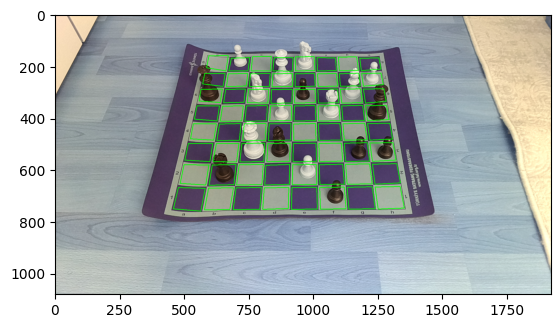

In [40]:
import cv2



# Load an existing image
image_path = "test-board.png"
image = cv2.imread(image_path)



# Iterate through the dictionary and draw shapes
for cell, coordinates in coord_dict.items():
    # Convert coordinates to a format suitable for polylines
    points = [tuple(coord) for coord in coordinates]
    points = np.array(points, np.int32)
    points = points.reshape((-1, 1, 2))
    
    # Draw the polygon
    cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)

plt.imshow(image)

<br><br>

## List that contains information about  Game 

<font size="4">

Inside of "board_conversion" function , there is a list called "game_list" , this list contains all the information about state of game
<br>
Position of pieces , square numbers 
<br>
This list is very important , it is going to be  used almost everytime 
<br><br>
When pressing letter "k" , this function starts to work , and it update game ( all pieces )
<br><br>

</font>

In [34]:
def board_conversion(detections):
    global game_list
    game_list=[]

    for detection in detections:
        
        x_mid = ((detection.xmin+detection.xmax)/2)*1920
        y_mid = ((detection.ymax+detection.ymin)/2)*1080 + 40
        
        for cell_value, coordinates in coord_dict.items():
            x_values = [point[0] for point in coordinates]
            y_values = [point[1] for point in coordinates]

            if (min(x_values) <= x_mid <= max(x_values)) and (min(y_values) <= y_mid <= max(y_values)):
                label_id=detection.label
                print(f" cell :  {cell_value} --> {label_id} --> {class_dict[label_id]} ")

                game_list.append([cell_value,label_id])

                break
         


<br><br>

## Calibration of Camera 

In [35]:
syncNN = True

# Create pipeline
pipeline = dai.Pipeline()

# Define sources and outputs
camRgb = pipeline.create(dai.node.ColorCamera)
detectionNetwork = pipeline.create(dai.node.YoloDetectionNetwork)

xoutRgb = pipeline.create(dai.node.XLinkOut)
nnOut = pipeline.create(dai.node.XLinkOut)

xoutRgb.setStreamName("rgb")
nnOut.setStreamName("nn")

# Properties
camRgb.setPreviewSize(640, 640)
camRgb.setResolution(dai.ColorCameraProperties.SensorResolution.THE_1080_P)
camRgb.setBoardSocket(dai.CameraBoardSocket.RGB)
camRgb.setInterleaved(False)
camRgb.setColorOrder(dai.ColorCameraProperties.ColorOrder.BGR)
camRgb.setPreviewKeepAspectRatio(False)
camRgb.setFps(20)

# Network specific settings
detectionNetwork.setConfidenceThreshold(0.4)
detectionNetwork.setNumClasses(12)
detectionNetwork.setCoordinateSize(4)
detectionNetwork.setAnchors([10, 14, 23, 27, 37, 58, 81, 82, 135, 169, 344, 319]) # Anchors are predefined bounding boxes with specific width and height ratios
detectionNetwork.setAnchorMasks({"side26": [1, 2, 3], "side13": [3, 4, 5]})
detectionNetwork.setIouThreshold(0.4)
detectionNetwork.setBlobPath(nnPath)
detectionNetwork.setNumInferenceThreads(2) # number of threads that the neural network node will use for inference
detectionNetwork.input.setBlocking(False) # network dont stop , maintain a smooth flow of data.

# Linking
"""
By linking camRgb.preview to detectionNetwork.input, you are specifying that the images from the 
RGB camera's preview output should be fed directly into the neural network for object detection
"""
camRgb.preview.link(detectionNetwork.input) # 640x640

# Ensures that the frames you display or process are the exact frames the NN used for its detections.
if syncNN:
    detectionNetwork.passthrough.link(xoutRgb.input)
else:
    camRgb.preview.link(xoutRgb.input)
    
detectionNetwork.out.link(nnOut.input)


# Connect to device and start pipeline
with dai.Device(pipeline) as device:

    print('Usb speed:', device.getUsbSpeed().name)

    # Output queues will be used to get the rgb frames and nn data from the outputs defined above
    qRgb = device.getOutputQueue(name="rgb", maxSize=4, blocking=False)
    qDet = device.getOutputQueue(name="nn", maxSize=4, blocking=False)

    frame = None
    detections = []
    startTime = time.monotonic()
    counter = 0
    color2 = (255, 255, 255)

    # nn data, being the bounding box locations, are in <0..1> range - they need to be normalized with frame width/height
    def frameNorm(frame, bbox):
        normVals = np.full(len(bbox), frame.shape[0])
        normVals[::2] = frame.shape[1]
        return (np.clip(np.array(bbox), 0, 1) * normVals).astype(int)

    def displayFrame(name, frame):
        color = (255, 0, 0)
        for detection in detections:
            # detection values are --> [0,1] range , inside board_conversion function they converted to cameras dimensions
            bbox = frameNorm(frame, (detection.xmin, detection.ymin, detection.xmax, detection.ymax))
           
           
            """
            print(detection.label)
            print(((detection.xmin+detection.xmax)/2)*1920)
            print(((detection.ymax+detection.ymin)/2)*1080+30) 
            """

            cv2.putText(frame, labelMap[detection.label], (bbox[0] + 10, bbox[1] + 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, 255)
            cv2.putText(frame, f"{int(detection.confidence * 100)}%", (bbox[0] + 10, bbox[1] + 40), cv2.FONT_HERSHEY_TRIPLEX, 0.5, 255)
            cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
        # Show the frame
        cv2.imshow(name, frame)

    while True:
        if syncNN:
            inRgb = qRgb.get()
            inDet = qDet.get()
        else:
            inRgb = qRgb.tryGet()
            inDet = qDet.tryGet()

        if inRgb is not None:
            frame = inRgb.getCvFrame()
            cv2.putText(frame, "NN fps: {:.2f}".format(counter / (time.monotonic() - startTime)),
                        (2, frame.shape[0] - 4), cv2.FONT_HERSHEY_TRIPLEX, 0.4, color2)

        if inDet is not None:
            detections = inDet.detections
           
            counter += 1

        if frame is not None:
            displayFrame("rgb", frame)

        # Wait for a key event for 1ms
        key = cv2.waitKey(1) & 0xFF
        if key == ord('k'):
            print("EXTRACTİON STARTS")
            cv2.imwrite("frame.png",frame)
            board_conversion(detections)
            
        if key == ord('q'):
            break

    cv2.destroyAllWindows()

C:\Users\sirom\AppData\Local\Temp\ipykernel_15332\1534464977.py:19: DeprecationWarning: RGB is deprecated, use CAM_A or address camera by name instead.
  camRgb.setBoardSocket(dai.CameraBoardSocket.RGB)


Usb speed: HIGH
EXTRACTİON STARTS
 cell :  10 --> 5 --> black-rook 
 cell :  43 --> 8 --> white-knight 
 cell :  61 --> 8 --> white-knight 
 cell :  6 --> 3 --> black-pawn 
 cell :  41 --> 1 --> black-king 
 cell :  36 --> 9 --> white-pawn 
 cell :  24 --> 3 --> black-pawn 
 cell :  13 --> 9 --> white-pawn 
 cell :  23 --> 3 --> black-pawn 
 cell :  40 --> 4 --> black-queen 
 cell :  52 --> 10 --> white-queen 
 cell :  45 --> 3 --> black-pawn 
 cell :  38 --> 11 --> white-rook 
 cell :  56 --> 9 --> white-pawn 
 cell :  58 --> 9 --> white-pawn 
 cell :  19 --> 7 --> white-king 
 cell :  47 --> 6 --> white-bishop 
 cell :  20 --> 1 --> black-king 


<br><BR><BR>

## Chess Board to String  ( string representation needs for conversion )

In [36]:


chess_str=""
for i in range(1, 65):
    
    for slist in game_list:
        if slist[0] == i:
            print(class_dict[slist[1]], end=" ")
            chess_str+=f" {class_dict[slist[1]]} "
            break
    else:
        print("space", end=" ")
        chess_str+=" space "

    if i % 8 == 0:
        print("\n")
        chess_str+="\n"
    
 

space space space space space black-pawn space space 

space black-rook space space white-pawn space space space 

space space white-king black-king space space black-pawn black-pawn 

space space space space space space space space 

space space space white-pawn space white-rook space black-queen 

black-king space white-knight space black-pawn space white-bishop space 

space space space white-queen space space space white-pawn 

space white-pawn space space white-knight space space space 



<br><br>

## String to SVG 

In [37]:
import chess
import chess.svg

def parse_coordinates(input_str):
    """
    Parse the input string to extract the positions of the chess pieces.
    """
    rows = input_str.strip().split('\n')
    chess_pieces = []
    for row in rows:  # Reversing rows to invert ranks
        pieces = row.strip().split()
        chess_pieces.extend(pieces)
    return chess_pieces


input_str=chess_str

chess_pieces = parse_coordinates(input_str)

board = chess.Board(None)

piece_mapping = {
    'white-pawn': chess.PAWN,
    'black-pawn': chess.PAWN,
    'white-knight': chess.KNIGHT,
    'black-knight': chess.KNIGHT,
    'white-bishop': chess.BISHOP,
    'black-bishop': chess.BISHOP,
    'white-rook': chess.ROOK,
    'black-rook': chess.ROOK,
    'white-queen': chess.QUEEN,
    'black-queen': chess.QUEEN,
    'white-king': chess.KING,
    'black-king': chess.KING,
    'space': None
}

for rank in range(8):
    for file in range(8):
        piece = chess_pieces[rank * 8 + file]
        if piece != 'space':
            print(rank)
            print(file)
            color = chess.WHITE if piece.startswith('white') else chess.BLACK
            piece_type = piece_mapping[piece]
            board.set_piece_at(chess.square(file, rank), chess.Piece(piece_type, color))  # Not inverting rank

svgboard = chess.svg.board(board)
with open("extracted-images/2Dboard.svg", "w") as f:
    f.write(svgboard)




0
5
1
1
1
4
2
2
2
3
2
6
2
7
4
3
4
5
4
7
5
0
5
2
5
4
5
6
6
3
6
7
7
1
7
4


## SVG to PNG

In [38]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM

# Function to convert SVG to PNG
def convert_svg_to_png(svg_file_path, png_file_path):
    # Read the SVG file and convert it to a ReportLab Drawing
    drawing = svg2rlg(svg_file_path)
    # Render the drawing to a PNG file
    renderPM.drawToFile(drawing, png_file_path, fmt='PNG')
    print(f"Converted {svg_file_path} to {png_file_path}")

# Example usage
svg_file = 'extracted-images/2Dboard.svg'
png_file = 'extracted-images/Extracted-Board.png'
convert_svg_to_png(svg_file, png_file)

Converted extracted-images/2Dboard.svg to extracted-images/Extracted-Board.png


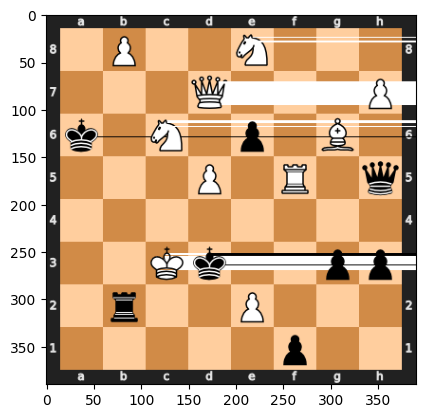

In [39]:
plt.imshow(cv2.cvtColor(cv2.imread("extracted-images/Extracted-Board.png"),cv2.COLOR_BGR2RGB))